In [5]:
import json
import numpy as np

In [6]:
with open('side-chain-multiple-data-extended/filenames.json') as json_file:
    data = json.load(json_file)

In [7]:
print('Train:=', len(data['train']))
print('Test:=', len(data['test']))
print('Validation:=', len(data['validation']))

Train:= 50017
Test:= 21532
Validation:= 10090


In [8]:
train_data = np.array([np.load(name.replace("*", "x"), allow_pickle = True) for name in data['train']])
train_y = np.array([np.load(name.replace("*", "y"), allow_pickle = True) for name in data['train']])

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import Bio.PDB as pdb
import json
from torch.nn import LSTM, Conv2d, Conv1d, Linear, Dropout, Sequential, Module, MaxPool2d, AvgPool2d, Flatten, BCELoss, Sigmoid, ReLU, Dropout2d, Dropout
from torch import cat, Tensor, reshape
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import functional as F

In [52]:
class ProteinGenerator(Dataset):
    def __init__(self, filenames, transpose=False):
        self._transpose = transpose
        self.filenames = filenames
        self.batch_size = 1
    
    def __len__(self):
        return (np.ceil(len(self.filenames) / float(self.batch_size))).astype(np.int)
    
    def __getitem__(self, idx):
        filenames = self.filenames[idx * self.batch_size:(idx+1) * self.batch_size]
        batch_x = np.array([np.load(name.replace("*", "x")) for name in filenames])
        batch_x = batch_x[0]
        batch_y = np.array([np.load(name.replace("*", "y")) for name in filenames])
        batch_y = batch_y[0]
        if self._transpose:
            batch_x = np.swapaxes(batch_x, 0, 1)
        return Tensor(np.swapaxes(np.swapaxes(batch_x, 0, 1), 0, 2)), Tensor(batch_y)

In [53]:
class NNConfig:
    def __init__(self, 
                 md, 
                 train_samp_gntr, 
                 test_samp_gntr,
                 loss_func,
                 optimizer,
                 n_epochs,
                 device = None):
        """
        :param md: torch.nn.Module subclass;
        :param train_samp_gntr: torch.utils.data.DataLoader subclass with train data;
        :param test_samp_gntr: torch.utils.data.DataLoader subclass with test data;
        :param loss_func: Loss function taken from torch.nn;
        :param optimizer: Optimizer taken from torch.optim;
        :param n_epochs: number of epochs to perform
        """
        self.md = md
        self.train_samp_gntr = train_samp_gntr
        self.test_samp_gntr = test_samp_gntr
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.device = device
    
    def fit(self, verbose=False, use_tqdm=False):
        epoch_range = range(self.n_epochs)
        batch_range = enumerate(self.train_samp_gntr)
        if use_tqdm:
            if "ZMQ" in get_ipython().__class__.__name__:
                from tqdm.notebook import tqdm
            else:
                from tqdm import tqdm
            epoch_range = tqdm(epoch_range)
            batch_range = tqdm(batch_range)
        self.md.train()#
        for epoch_ind in epoch_range:
            if verbose:
                print(f"epoch {epoch_ind} started")
            for i, (X, y) in batch_range:
                if self.device:
                    X = X.to(self.device)
                    y = y.to(self.device)
                self.optimizer.zero_grad()#
                y_pred = self.md(X)
                pred_loss = self.loss_func(y_pred, y)
                pred_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.md.parameters(), 1)#
                self.optimizer.step()
                if i % 10 == 0:
                    print("\tEpoch {}, Step {}. Loss: {}".format(epoch_ind, i, pred_loss.item()))
                    
                    
    def predict(self, tr=False, X=None):
        """
        :param X: input to make prediction. If None, make prediction to all test samples.
        """
        self.md.eval()
        prediction = []

        if X == None:
            with open("./side-chain-multiple-data-extended/filenames.json") as f:
                filenames = json.loads(f.read())
            test_set = ProteinGenerator(filenames["test"], transpose=tr)
            X = DataLoader(test_set, batch_size=1, shuffle=True)
        with torch.no_grad():
            for x, _ in X:
                if self.device:
                    x = x.to(self.device)
                pred = self.md(x)
                prediction.append(pred)
        return prediction

### 1. input -> Linear -> output

In [60]:
class Net1_2(Module):
    def __init__(self):
        super().__init__()

        
        self.lin1 = Linear(in_features=199, out_features=128)
        self.act1 = ReLU()
        self.bn1 = torch.nn.BatchNorm1d(64)
        
        self.lin2 = Linear(in_features=128, out_features=64)
        self.act2 = ReLU()
        
        self.lin3 = Linear(in_features=64, out_features=36)
        self.out_activation = Sigmoid()
        
        
    def forward(self, x):
        out = torch.squeeze(x, 1)
        out = self.lin1(out)
        out = self.act1(out)
        out = self.bn1(out)
#         out = self.act2(out)
        out = self.lin2(out)
        out = self.act2(out)
        out = self.lin3(out)
        out = self.out_activation(out)
        return out

In [61]:
BATCH_SIZE = 128 

In [62]:
train_set = ProteinGenerator(data["train"], transpose=False)
train_generator = DataLoader(train_set, 
                             batch_size=BATCH_SIZE, 
                             shuffle=True)

In [63]:
structures = []
md1 = Net1_2()
loss_func = BCELoss()
optimizer = Adam(md1.parameters())
structures += [NNConfig(md1, train_generator, None, loss_func, optimizer, 1, None)]



In [1]:
structures[0].fit(use_tqdm=True)

In [72]:
pred = structures[0].predict(tr=False)

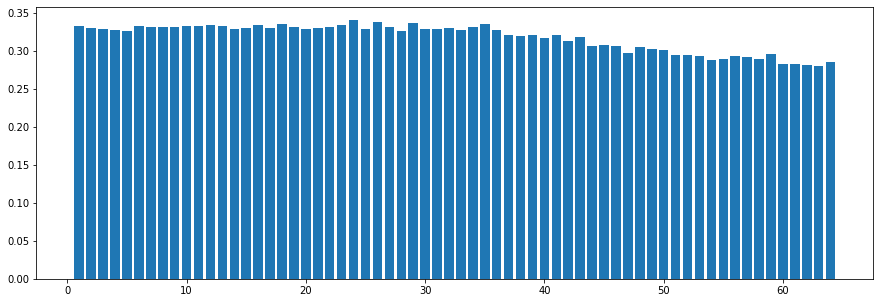

In [88]:
plt.figure(figsize=(15,5))
plt.bar(np.arange(1, 65), np.nansum(accs, axis=0)  / np.count_nonzero(~np.isnan(accs), axis=0))
# plt.savefig("accs_nans.png")
plt.show()

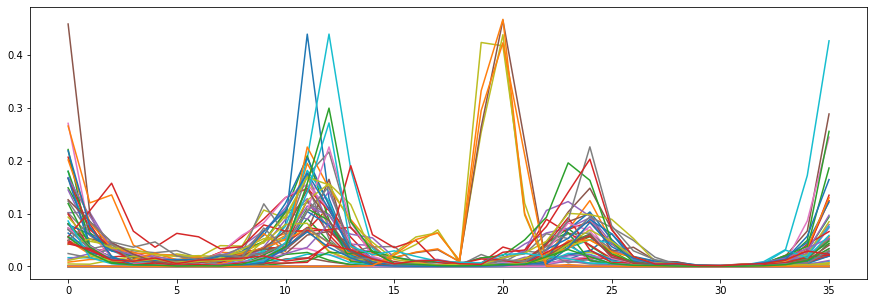

In [90]:
plt.figure(figsize=(15,5))
for i in range(64):
    plt.plot(np.arange(0, 36), pred[1][0][i].cpu())
plt.show()

In [96]:
accs_2 = []  ###
test_generator = ProteinGenerator(data["test"], transpose=False)
for i in range(len(test_generator)):
    x,y_true = test_generator[i]
    y_pred = pred[i]
    accs_2.append(rotamer_accuracy(y_pred.cpu(), y_true, rotamer_bin_radius=3))



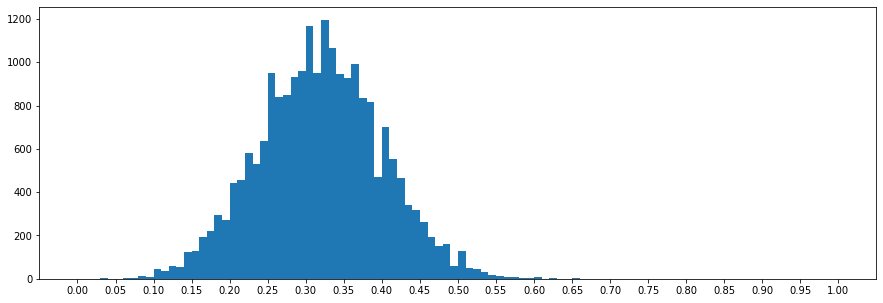

In [97]:
# extended with rad 5

plt.figure(figsize=(15,5))
plt.hist(accs_2, bins=100, range=(0,1))
plt.xticks(np.arange(0,1.05,0.05))
plt.savefig("accs_bn.png")
plt.show()